In [39]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [40]:
# 文件的路径
sample_path = "~/Desktop/Cases_1/苏州工业园/Electric power load data/2018/1_hour/2018_1hour_Commercial/20180101_1hour_Commercial.xlsx"
sample_path = os.path.expanduser(sample_path)

# 读取文件头部几行
df = pd.read_excel(sample_path)
print("列名如下：")
print(df.columns)

# 设置文件夹路径
folder_path = os.path.expanduser("~/Desktop/Cases_1/苏州工业园/Electric power load data/2018/1_hour/2018_1hour_Commercial")

# 获取所有 .xlsx 文件
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx')])

# 创建空 DataFrame 用于合并
combined_df = pd.DataFrame()

列名如下：
Index(['Time', 'Power (kW)'], dtype='object')


In [41]:
# 遍历每个文件
for filename in file_list:
    try:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_excel(file_path, engine='openpyxl')  # 显式指定 engine
        
        # 标准化列名
        df.columns = [col.strip().replace('\n', '').replace('\r', '').lower() for col in df.columns]
        #  print(f"✔ 读取 {filename} 的列名为：{df.columns.tolist()}")
        
        # 判断列名是否存在
        if 'time' in df.columns and 'power (kw)' in df.columns:
            df = df[['time', 'power (kw)']]
            df['SourceFileDate'] = filename[:8]
            
            # 转换类型
            df['time'] = pd.to_datetime(df['time'])
            df['SourceFileDate'] = pd.to_datetime(df['SourceFileDate'])
            
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        else:
            raise ValueError("列名不符合预期：'time' 和 'power (kw)' 不存在")
    
    except Exception as e:
        print(f"跳过文件 {filename}, 原因: {e}")


# 保存最终合并的 CSV
combined_df.to_csv("Office_2018_1hour_long_commercial.csv", index=False)
print("成功导出为 'Office_2018_1hour_long_commercial.csv'")

成功导出为 'Office_2018_1hour_long_commercial.csv'


In [42]:
df = pd.read_csv("Office_2018_1hour_long_commercial.csv", encoding='utf-8-sig')
df.columns = [col.strip().lower() for col in df.columns]  # 统一小写 + 去空格

# 统一时间格式
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.time

# 去重，只保留第一条记录
df = df.drop_duplicates(subset=['date', 'hour'], keep='first')

# 生成每天一行，每小时一列的负载矩阵
pivot_df = df.pivot(index='date', columns='hour', values='power (kw)').reset_index()
pivot_df.to_csv("daily_load_matrix.csv", index=False)

print("已成功生成 daily_load_matrix.csv（重复已处理）")

已成功生成 daily_load_matrix.csv（重复已处理）


In [43]:
pivot_df = pd.read_csv("daily_load_matrix.csv")
# 插值 + 双向填充
pivot_df_interp = pivot_df.set_index('date')
pivot_df_interp = pivot_df_interp.interpolate(axis=1, limit_direction='both')
pivot_df_interp = pivot_df_interp.ffill(axis=1).bfill(axis=1)

# 丢掉真的没救的数据（全为空行）
pivot_df_interp = pivot_df_interp.dropna(thresh=10)  # 至少保留10小时数据
pivot_df_interp = pivot_df_interp.reset_index()

In [44]:
pivot_df_interp.shape     
pivot_df_interp.head()

,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,2018-01-01,840.76,712.29,585.82,520.49,422.83,440.22,457.37,464.70,539.04,...,757.79,785.94,868.97,871.56,1017.69,1106.48,1117.63,1190.40,1214.36,1222.72
1,2018-01-02,1077.68,799.22,586.62,439.24,425.22,445.64,464.01,437.59,826.60,...,727.33,666.75,887.36,883.71,991.66,1023.16,1111.19,1156.97,1216.76,1283.16
2,2018-01-03,1046.62,795.52,543.24,455.43,436.98,434.15,450.82,495.98,794.02,...,819.40,836.24,965.83,910.99,1026.54,1111.92,1299.45,1322.60,1344.36,1395.33
3,2018-01-04,1135.85,833.76,600.71,486.98,468.55,457.12,485.96,528.81,884.42,...,841.88,858.92,978.10,1066.80,1139.59,1190.79,1358.59,1391.72,1482.02,1432.91
4,2018-01-05,1256.29,882.33,690.72,560.69,477.88,502.62,568.03,582.46,949.76,...,810.81,754.89,967.34,941.95,1194.37,1249.04,1329.17,1400.76,1379.05,1430.73


In [45]:
X = pivot_df_interp.select_dtypes(include='number')
print(X.isna().sum().sum())  # 输出所有 NaN 的总数

0


In [46]:
ar

In [47]:
print(pivot_df_interp[['date', 'cluster']].head())

         date  cluster
0  2018-01-01        0
1  2018-01-02        0
2  2018-01-03        0
3  2018-01-04        2
4  2018-01-05        2


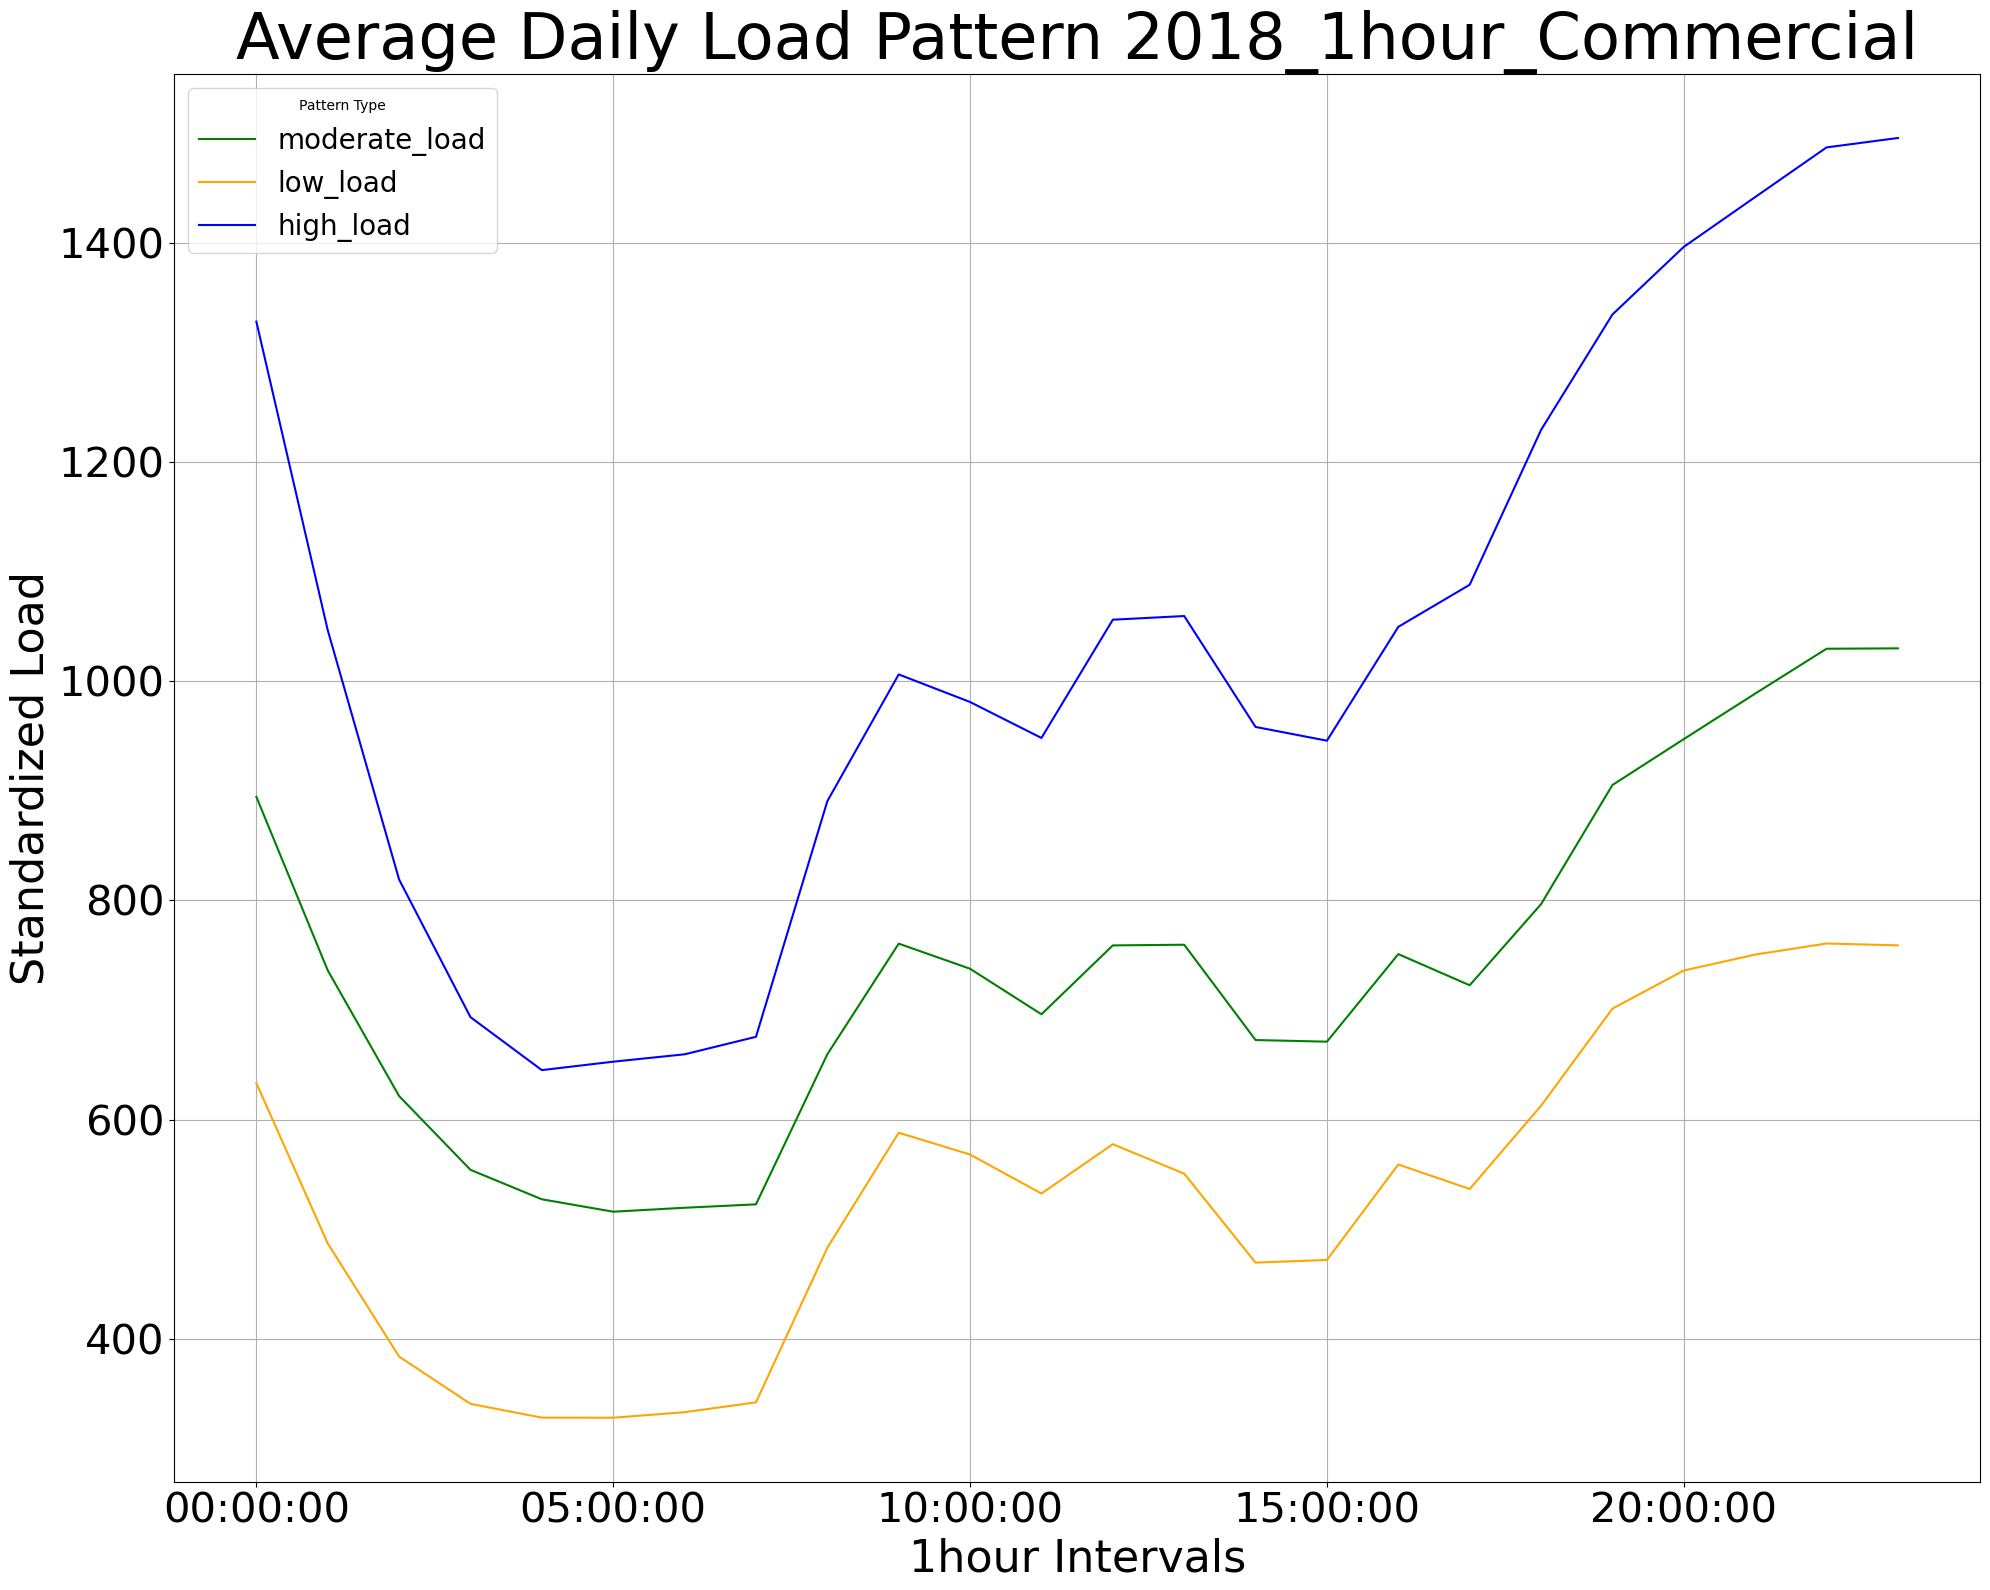

In [48]:
load_columns = pivot_df_interp.select_dtypes(include='number').columns.drop('cluster')

# Ensure clustering has been done and column exists
assert 'cluster' in pivot_df_interp.columns, "Missing 'cluster' column. Run KMeans first."

# Group by cluster, average the first 96 load columns
avg_by_label = pivot_df_interp.groupby("cluster")[load_columns].mean()

# Define custom labels
cluster_name_map = {
    0: "moderate_load",
    1: "low_load",
    2: "high_load"
}
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
# Rename cluster index to meaningful names
avg_by_label.index = avg_by_label.index.map(cluster_name_map)

color_map={
    "moderate_load":"green",
    "low_load":"orange",
    "high_load":"blue"
}

colors = [color_map.get(name, 'gray') for name in avg_by_label.index]

# Plot
avg_by_label.T.plot(figsize=(20, 16),color=colors)

plt.title("Average Daily Load Pattern 2018_1hour_Commercial", fontsize=46)
plt.xlabel("1hour Intervals", fontsize=32)
plt.ylabel("Standardized Load", fontsize=32)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(title="Pattern Type", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

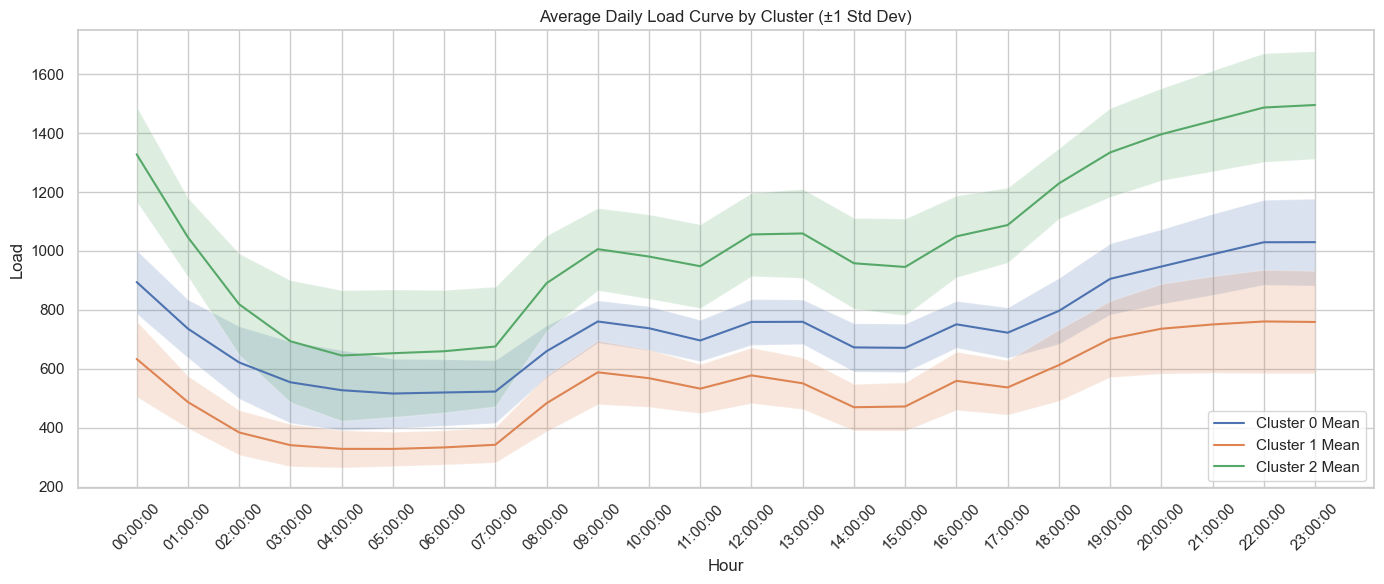

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your clustered daily load data
df = pd.read_csv("daily_load_with_clusters_and_labels_2018_1hr_Commercial.csv")

# Extract hourly columns (assumes HH:MM:SS format)
hourly_cols = [col for col in df.columns if ':' in col and len(col) == 8]

# Set up the plot
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

# Plot average + std for each cluster
for cluster_id in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster_id][hourly_cols]
    mean_profile = cluster_df.mean()
    std_profile = cluster_df.std()

    plt.plot(mean_profile.index, mean_profile.values, label=f"Cluster {cluster_id} Mean")
    plt.fill_between(mean_profile.index,
                     mean_profile - std_profile,
                     mean_profile + std_profile,
                     alpha=0.2)

# Plot settings
plt.title("Average Daily Load Curve by Cluster (±1 Std Dev)")
plt.xlabel("Hour")
plt.ylabel("Load")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
cluster_name_map = {
    0: "moderate_load",
    1: "low_load",
    2: "high_load"
}
for c in sorted(pivot_df_interp['cluster'].unique()):
    name = cluster_name_map[c]
    print(f"\nCluster {c} ({name}):")
    dates = pivot_df_interp[pivot_df_interp['cluster'] == c]['date'].tolist()
    print(dates[:10])


Cluster 0 (moderate_load):
['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-14', '2018-01-15', '2018-01-16', '2018-01-17', '2018-01-19', '2018-01-20', '2018-01-21']

Cluster 1 (low_load):
['2018-01-22', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13']

Cluster 2 (high_load):
['2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-13']


In [12]:
pivot_df_interp.to_csv("daily_load_with_clusters_and_labels_2018_1hour_Commercial.csv")

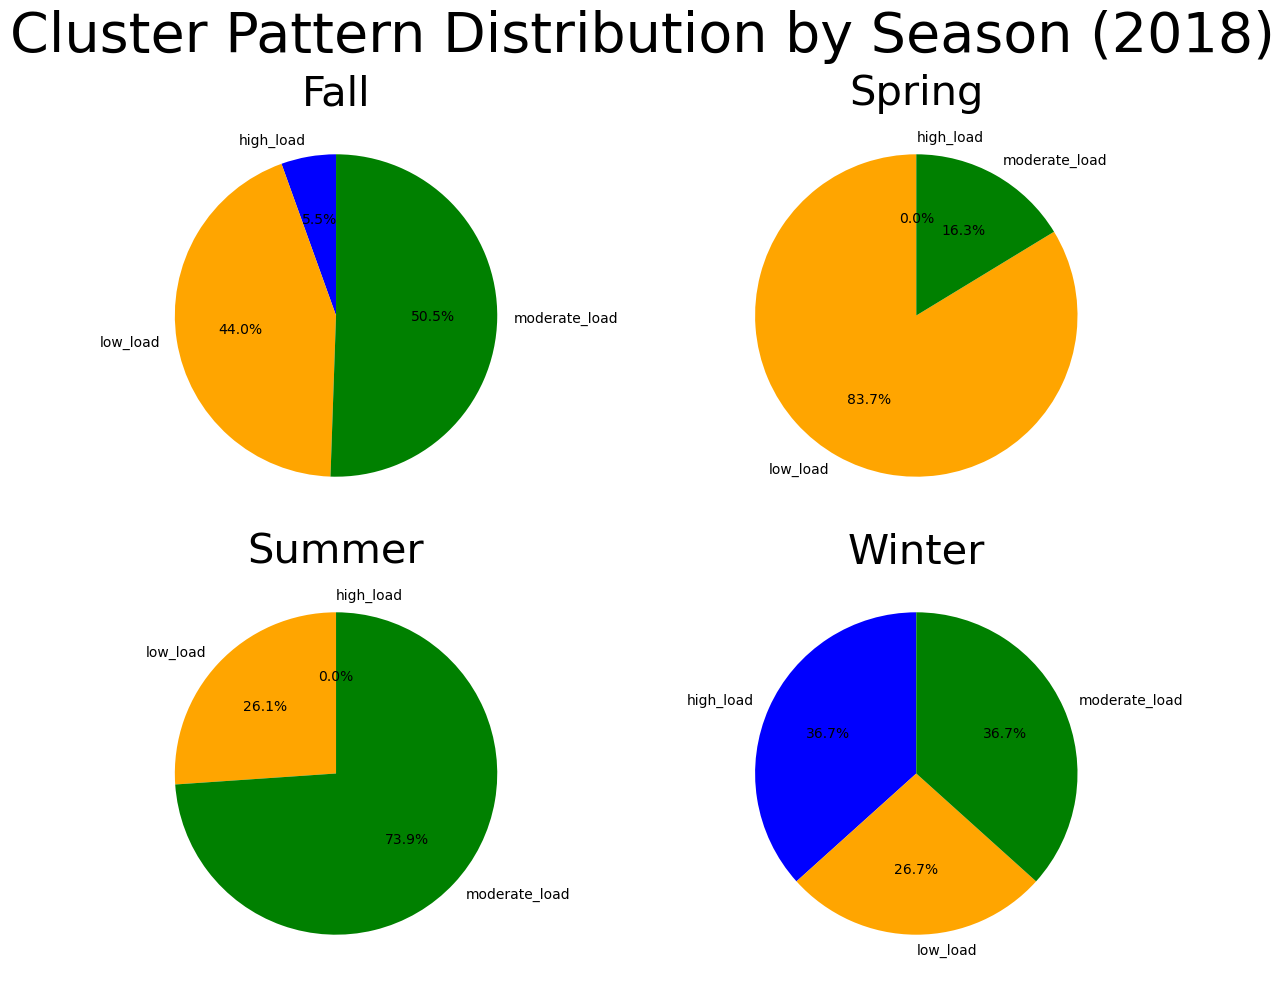

In [25]:
pivot_df_interp['date'] = pd.to_datetime(pivot_df_interp['date'])

def get_season(date):
    m = date.month
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)
pattern_by_season = pivot_df_interp.groupby(['season', 'pattern']).size().unstack(fill_value=0)

seasons = pattern_by_season.index.tolist()
labels = pattern_by_season.columns.tolist()

# Define color mapping
color_dict = {
    'low_load': 'orange',
    'high_load': 'blue',
    'moderate_load':'green'
}
# Assign default color if pattern not in the dictionary
colors = [color_dict.get(label, 'gray') for label in labels]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of pie charts

for i, season in enumerate(seasons):
    ax = axes[i // 2, i % 2]
    ax.pie(
        pattern_by_season.loc[season], 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=colors
    )
    ax.set_title(f"{season}",fontsize=30)

plt.suptitle("Cluster Pattern Distribution by Season (2018)",fontsize=40)
plt.tight_layout()
plt.show()

season
Spring    13624.019457
Fall      16218.586154
Summer    16870.373859
Winter    18463.169167
Name: total_load, dtype: float64


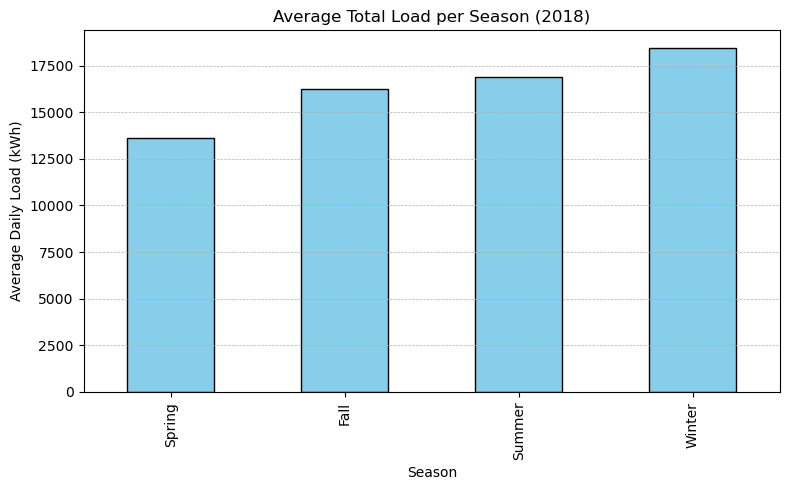

In [37]:
# 1. Assign season
pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)

# 2. Compute total load per day
load_columns = pivot_df_interp.select_dtypes(include='number').columns.drop('cluster', errors='ignore')  # safely drop cluster if exists
pivot_df_interp['total_load'] = pivot_df_interp[load_columns].sum(axis=1)

# 3. Compute seasonal average total load
season_avg = pivot_df_interp.groupby('season')['total_load'].mean().sort_values()
print(season_avg)

# 4. Optional: Visualize
season_avg.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(8,5))
plt.title("Average Total Load per Season (2018)")
plt.ylabel("Average Daily Load (kWh)")
plt.xlabel("Season")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

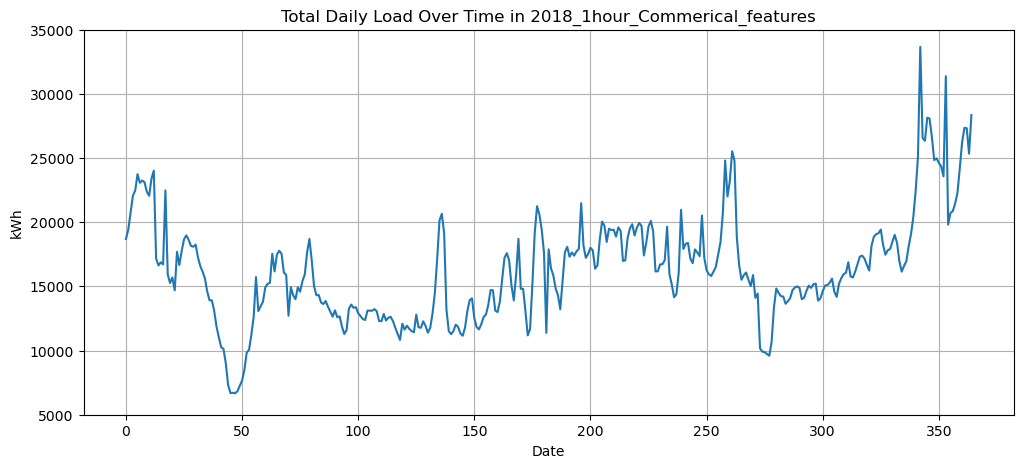

In [26]:
# 1. 完成所有预处理（插值、聚类、添加 pattern 和 season）
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)

# 2. 必须在这里清洗列名！所有后续都基于它！
pivot_df_interp.columns = pivot_df_interp.columns.map(str)

# 3. 抓负载列（非 date / cluster / pattern / season）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

# 4. 提取特征（注意 idxmax 前，列名必须是 string）
features_df = pd.DataFrame(index=pivot_df_interp.index)
features_df["total_load"] = pivot_df_interp[load_columns].sum(axis=1)
features_df["peak_load"] = pivot_df_interp[load_columns].max(axis=1)
features_df["valley_load"] = pivot_df_interp[load_columns].min(axis=1)
features_df["load_range"] = features_df["peak_load"] - features_df["valley_load"]
features_df["load_std"] = pivot_df_interp[load_columns].std(axis=1)
features_df["time_of_peak"] = pivot_df_interp[load_columns].idxmax(axis=1)
features_df["time_of_valley"] = pivot_df_interp[load_columns].idxmin(axis=1)

# 5.把时间截干净
features_df["time_of_peak"] = features_df["time_of_peak"].str[-8:]
features_df["time_of_valley"] = features_df["time_of_valley"].str[-8:]

# ✅ Plot with fixed y-axis range (5000–35000)
features_df["total_load"].plot(
    figsize=(12, 5),
    title="Total Daily Load Over Time in 2018_1hour_Commerical_features"
)
plt.xlabel("Date")
plt.ylabel("kWh")
plt.ylim(5000, 35000)  # <-- Set Y-axis limits here
plt.grid(True)
plt.show()


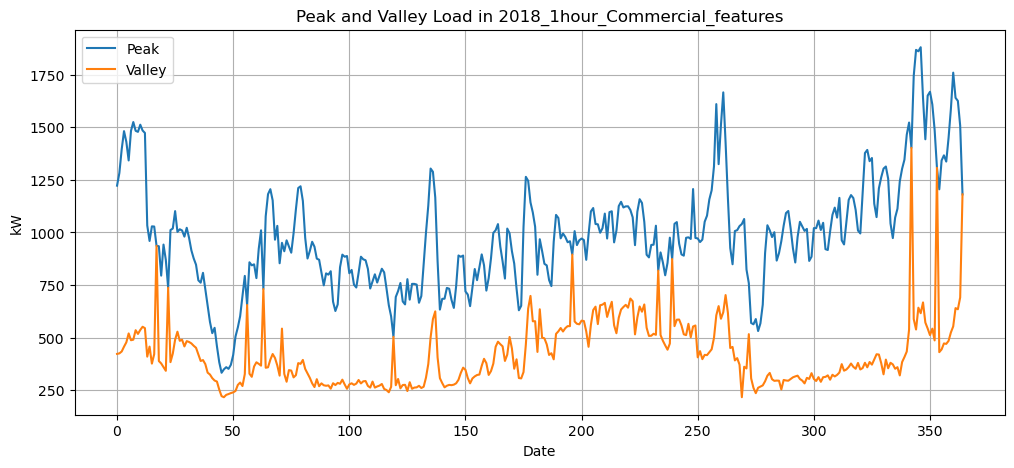

In [27]:
features_df[["peak_load", "valley_load"]].plot(figsize=(12, 5), title="Peak and Valley Load in 2018_1hour_Commercial_features")
plt.xlabel("Date")
plt.ylabel("kW")
plt.legend(["Peak", "Valley"])
plt.grid(True)
plt.show()

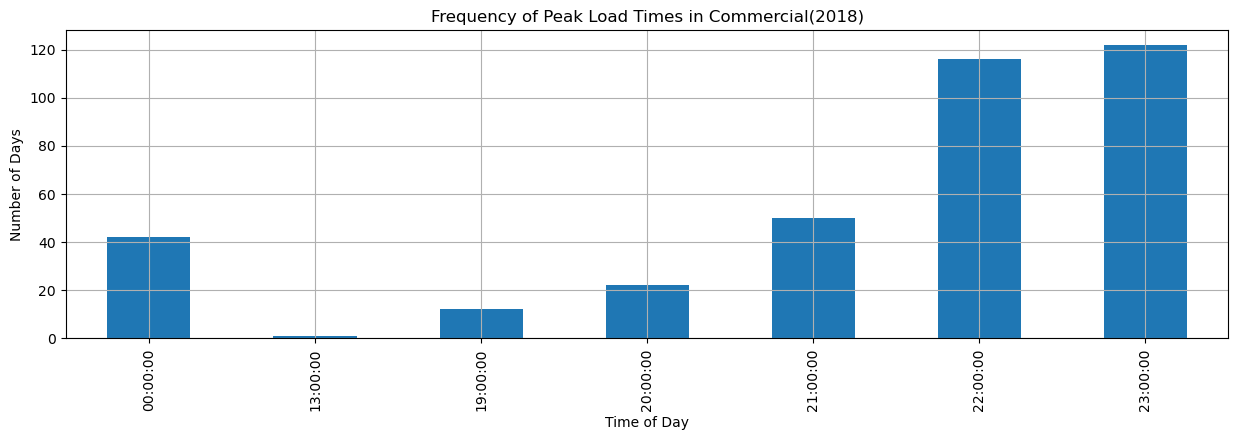

In [28]:
features_df["time_of_peak"].value_counts().sort_index().plot(kind="bar", figsize=(15, 4), title="Frequency of Peak Load Times in Commercial(2018)")
plt.xlabel("Time of Day")
plt.ylabel("Number of Days")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

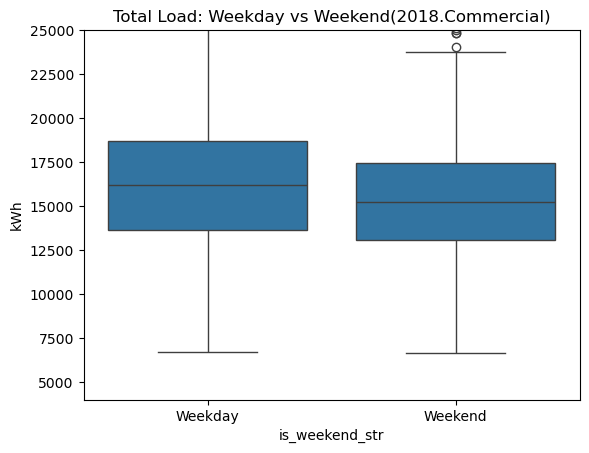

In [29]:
features_df['is_weekend'] = pivot_df_interp['date'].dt.weekday >= 5
features_df['is_weekend_str'] = features_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
features_df["is_weekend_str"] = features_df["is_weekend"].map({True: "Weekend", False: "Weekday"})
sns.boxplot(x="is_weekend_str", y="total_load", data=features_df)
plt.title("Total Load: Weekday vs Weekend(2018.Commercial)")
plt.ylabel("kWh")
plt.ylim(4000, 25000)
plt.show()

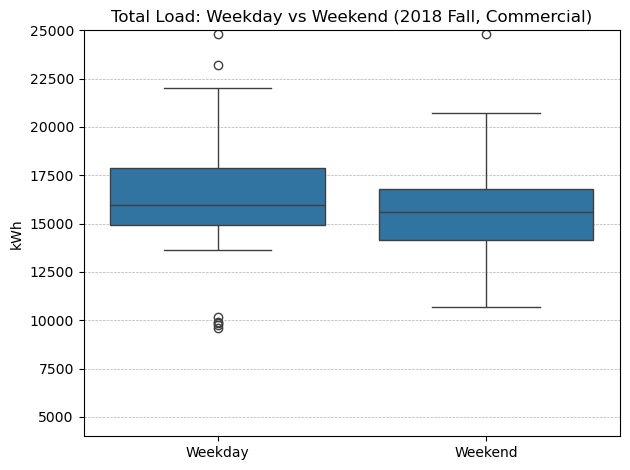

In [36]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

features_df['season'] = pivot_df_interp['date'].apply(get_season)

Fall_df = features_df[features_df['season'] == 'Fall']

sns.boxplot(
    x="is_weekend_str",
    y="total_load",
    data=Fall_df,
    order=["Weekday", "Weekend"]  # 🔁 Force this order!
)

plt.title("Total Load: Weekday vs Weekend (2018 Fall, Commercial)")
plt.ylabel("kWh")
plt.xlabel("")  # Optional
plt.ylim(4000, 25000)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

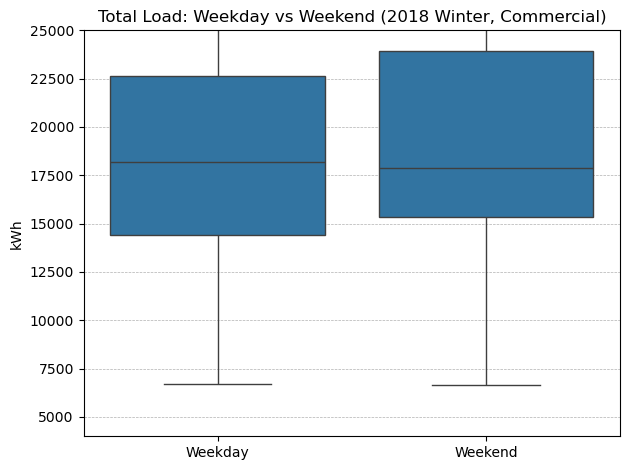

In [35]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

features_df['season'] = pivot_df_interp['date'].apply(get_season)

Winter_df = features_df[features_df['season'] == 'Winter']

sns.boxplot(
    x="is_weekend_str",
    y="total_load",
    data=Winter_df,
    order=["Weekday", "Weekend"]  # 🔁 Force this order!
)

plt.title("Total Load: Weekday vs Weekend (2018 Winter, Commercial)")
plt.ylabel("kWh")
plt.xlabel("")  # Optional
plt.ylim(4000, 25000)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

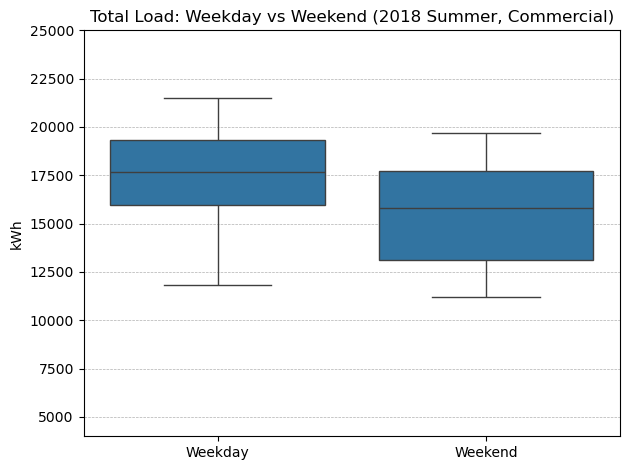

In [33]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

features_df['season'] = pivot_df_interp['date'].apply(get_season)

summer_df = features_df[features_df['season'] == 'Summer']
sns.boxplot(x="is_weekend_str", y="total_load", data=summer_df)
plt.title("Total Load: Weekday vs Weekend (2018 Summer, Commercial)")
plt.ylabel("kWh")
plt.ylim(4000, 25000)
plt.xlabel("")  # Optional, cleaner look
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

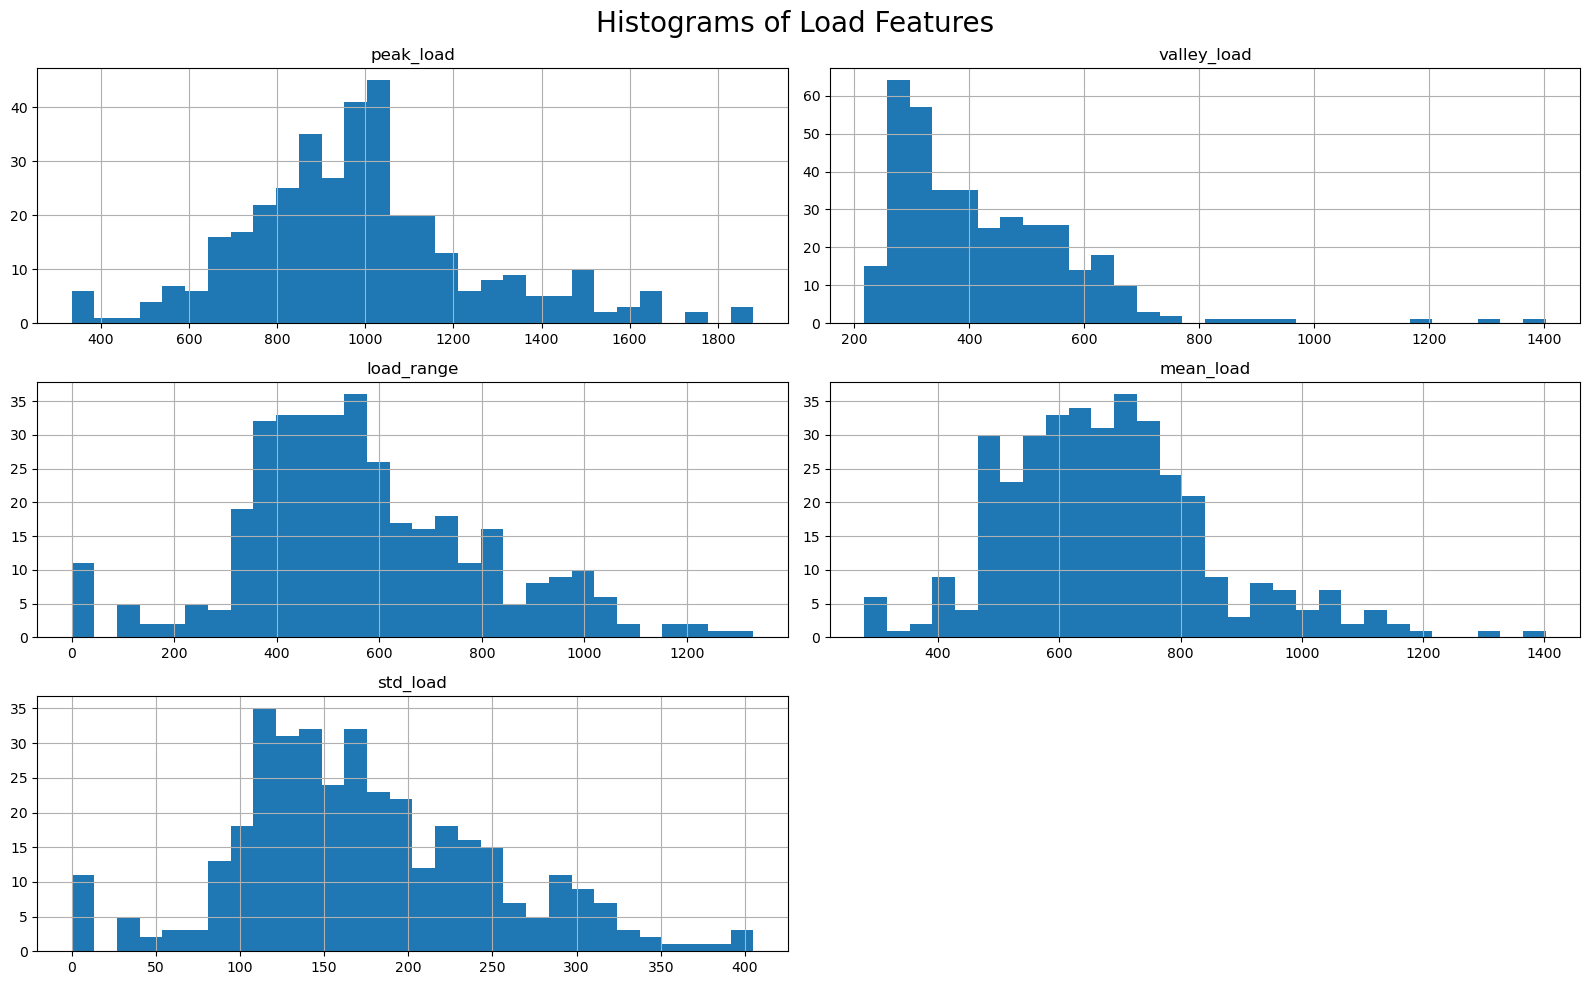

In [18]:
feature_df = pd.DataFrame(index=pivot_df_interp.index)

# 选择中间的负载列（避开 date, cluster 等）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

feature_df['peak_load'] = pivot_df_interp[load_columns].max(axis=1)
feature_df['valley_load'] = pivot_df_interp[load_columns].min(axis=1)
feature_df['load_range'] = feature_df['peak_load'] - feature_df['valley_load']
feature_df['mean_load'] = pivot_df_interp[load_columns].mean(axis=1)
feature_df['std_load'] = pivot_df_interp[load_columns].std(axis=1)
feature_df['load_factor'] = feature_df['mean_load'] / feature_df['peak_load']
feature_df['peak_time'] = pivot_df_interp[load_columns].idxmax(axis=1)
feature_df['valley_time'] = pivot_df_interp[load_columns].idxmin(axis=1)
plt.figure(figsize=(16, 10))
feature_df[['peak_load', 'valley_load', 'load_range', 'mean_load', 'std_load']].hist(bins=30, figsize=(16, 10))
plt.suptitle("Histograms of Load Features", fontsize=20)
plt.tight_layout()
plt.show()